In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
import tensorflow as tf
import numpy as np
import cv2

import rcnn.simple_nn as nn
from rcnn.video_parser import get_data
from rcnn.data_generators import get_anchor, video_streamer

import pickle

from matplotlib import pyplot as plt

Using TensorFlow backend.


In [3]:
from random import seed
seed(1234)
np.random.seed(1234)

In [4]:
data,_,_ = get_data('./crowdgen_data/Main/', './annotations/')

Parsing annotation files


In [5]:
with open('config.pickle', 'rb') as f:
    C = pickle.load(f)

In [6]:
data_gen = video_streamer(data, 2, C, lambda x,y: [x,y], 'tf', 'test')

In [7]:
x = next(data_gen)

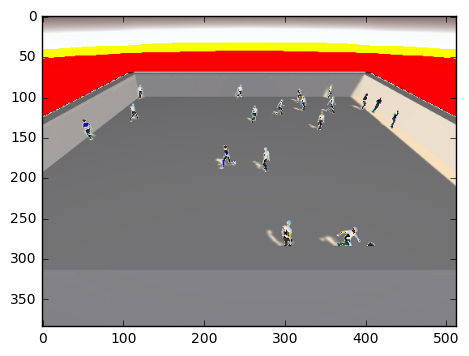

In [8]:
plt.imshow(x[0][0,1])
plt.show()

In [9]:
num_anchors = len(C.anchor_box_ratios) * len(C.anchor_box_scales)

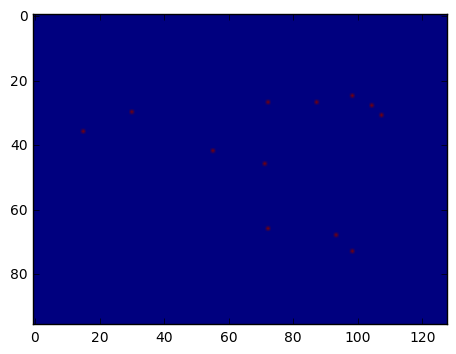

In [10]:
plt.imshow((x[1][0][0,1][...,num_anchors:]).sum(axis=-1))
plt.show()

In [11]:
sess = tf.Session()

In [12]:
video_input = tf.placeholder(tf.float32, [None,None,None,None,3], name='video_input')
roi_input = tf.placeholder(tf.int64, [None,None,4], name='roi_input')
feature_map_input = tf.placeholder(tf.float32, [1, None, None, nn.shared_dim], 'feature_map_input')

In [13]:
C.num_rois = 32

In [14]:
base = nn.build_shared(video_input)
rpn = nn.build_rpn(base, num_anchors)

classifier = nn.classifier(roi_input, C.num_rois, nb_classes=len(C.class_mapping), trainable=False)(feature_map_input)

In [15]:
saver = tf.train.Saver()

In [16]:
class_mapping = C.class_mapping
class_mapping = {v: k for k, v in class_mapping.items()}

print(class_mapping)

class_to_color = {class_mapping[v]: np.random.randint(0, 255, 3) for v in class_mapping}

{0: 'bbox', 1: 'bg'}


In [17]:
rpn[0] = tf.nn.sigmoid(rpn[0])
classifier[0] = tf.nn.softmax(classifier[0])

#ROIs = []

def predict_rpn_and_featuremap(X):
    return sess.run(rpn + [base], {video_input:X})

def predict_classifier(features, ROI):
    #global ROIs
    #ROIs.append(ROI)
    return sess.run(classifier, {feature_map_input: features, roi_input:ROI})

In [24]:
saver.restore(sess, './experiment_save/with_det')

INFO:tensorflow:Restoring parameters from ./experiment_save/with_det


In [25]:
from rcnn.prediction_to_bb import extract_for_det, extract_for_rpn

In [26]:
extract_for_rpn(x[0][0], C)
print('1')

1


In [27]:
preds_n_base = predict_rpn_and_featuremap(x[0])

In [28]:
Y1, Y2, base_ = preds_n_base

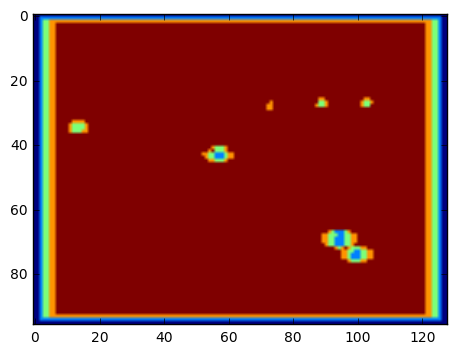

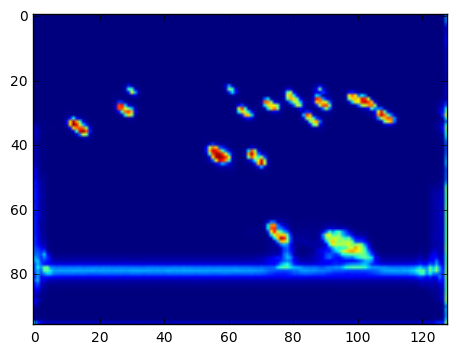

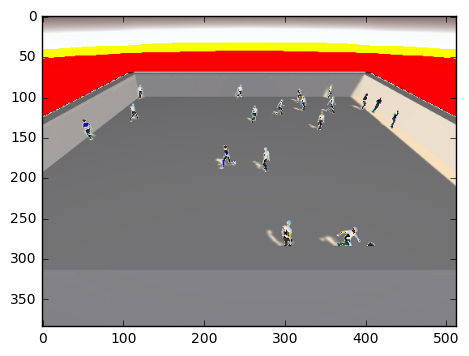

In [29]:
t = 1
plt.imshow((x[1][0][0,t][...,:num_anchors]).sum(axis=-1))
plt.show()
plt.imshow(Y1[0,t].max(axis=-1))
plt.show()
plt.imshow(x[0][0,t])
plt.show()

In [30]:
bbs = extract_for_det(Y1[:,t], Y2[:,t], base_[:,t], predict_classifier, C)

In [31]:
bbs

[[220, 160, 240, 188],
 [428, 116, 440, 140],
 [108, 108, 120, 132],
 [272, 164, 280, 196],
 [408, 100, 420, 120],
 [288, 104, 300, 124],
 [48, 128, 64, 156],
 [296, 252, 308, 292],
 [360, 264, 396, 300],
 [256, 112, 268, 132],
 [392, 96, 404, 116],
 [240, 88, 248, 104],
 [340, 120, 348, 144],
 [316, 96, 324, 116],
 [0, 300, 24, 340],
 [352, 100, 364, 120],
 [392, 280, 420, 316],
 [460, 300, 496, 340],
 [492, 108, 504, 128],
 [448, 300, 480, 340]]

In [32]:
preds = predict_rpn_and_featuremap(x[0])[0]

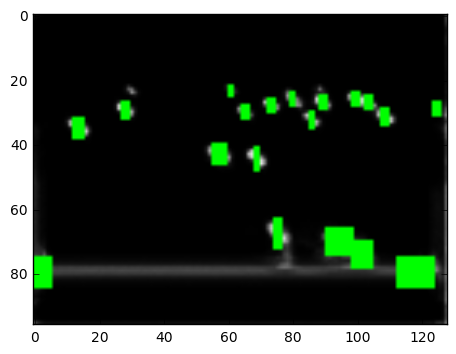

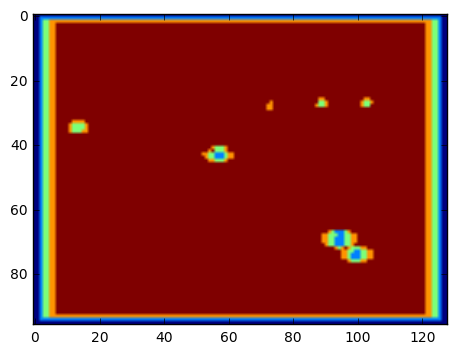

In [33]:
im = preds[0,t].max(axis=-1)
im = np.stack([im]*3,  axis=-1)
for bb in bbs:
    a,b,c,d = map(lambda x: x//C.rpn_stride, bb)
    #cv2.rectangle(im, (a,b), (c,d), color=-1)
    im[b:d,a:c] = np.array([0,255,0], dtype='float32')/255
plt.imshow(im, vmin=0, vmax=1)
plt.show()
plt.imshow((x[1][0][0,t][...,:num_anchors]).sum(axis=-1))
plt.show()

In [90]:
a, b, c, d

(29, 0, 31, 4)

In [69]:
preds[0,19][4:-4,4:-4].max(), preds[0,19].min(), preds[0,19].mean()

(0.99956459, 2.0819032e-18, 0.01933773)

In [29]:
#for bb in ROIs[0][0]:
#    im = preds[0,16].max(axis=-1)
#    a,b,c,d = bb
#    
#    c += a
#    d += b
#    
#    cv2.rectangle(im, (a,b), (c,d), 1000)
#    plt.imshow(im, vmin=0, vmax=1)
#    plt.show()